# BereaCubic

This example is reproduction of the paper by Ioannidis and Chatzis: [Network Modelling of Pore Structure and Transport Properties of Porous Media](https://doi.org/10.1016/0009-2509(93)80333-L).

In their work, they generated a Cubic lattice network that reproduced the behavior of Berea Sandstone. Berea Sandstone is one of the standard materials used on geoscience studies due to it's importance in oil reservoir engineering as well as having well defined pore structure.  

This example illustrates how to use OpenPNM to generate a network model of Berea using the BereaCubic class, with the appropriate lattice spacing and geometrical properties.


In [16]:
import openpnm as op
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import image

OpenPNM V2 includes a ``materials`` module that contains *recipes* for numerous commonly used porous materials.  Because the network topology and geometry are tightly coupled, these recipes return both a ``network`` and a ``geometry``, packaged together in a ``project``.  This is illustrated for ``BereaCubic`` as follows:

In [ ]:
proj = op.materials.BereaCubic(shape=[15, 15, 15])

An OpenPNM `project` is a Python `list` containing the network and all the associated objects.  Printing it reveals that it contains a network and a geometry:

In [6]:
print(proj)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
 Object Name     Object ID                                                        
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
 net_01          <openpnm.network.Cubic object at 0x292cde23728>                  
 geo_01          <openpnm.geometry.GenericGeometry object at 0x292c46159e8>       
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


The network and geometry objects can be fetched from the list and stored in corresponding handles:

In [7]:
net = proj.network
geo = proj[1]

The network object can be printed as shown below.  

In [4]:
print(net)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
openpnm.network.Cubic : net_01
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
#     Properties                                    Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
1     pore.coords                                    3375 / 3375 
2     throat.conns                                   9450 / 9450 
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
#     Labels                                        Assigned Locations
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
1     pore.all                                      3375      
2     pore.back                                     225       
3     pore.bottom                                   225       
4     pore.front                                    225       
5     pore.geo_01                                   33

We can also inspect the geometry object, which contains all the geometrical information such as pore size distributions.

In [42]:
print(geo)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
openpnm.geometry.GenericGeometry : geo_01
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
#     Properties                                    Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
1     pore.seed                                      3375 / 3375 
2     pore.size_x                                    3375 / 3375 
3     pore.size_y                                    3375 / 3375 
4     pore.size_z                                    3375 / 3375 
5     pore.volume                                    3375 / 3375 
6     throat.area                                    9450 / 9450 
7     throat.height                                  9450 / 9450 
8     throat.length                                  9450 / 9450 
9     throat.seed                                    9450 / 9450 
10    throat.size                                    9450 / 94

Let's look at the distribution of pore and throat sizes in the system, and compare with those from the original paper:

(-0.5, 1097.5, 719.5, -0.5)

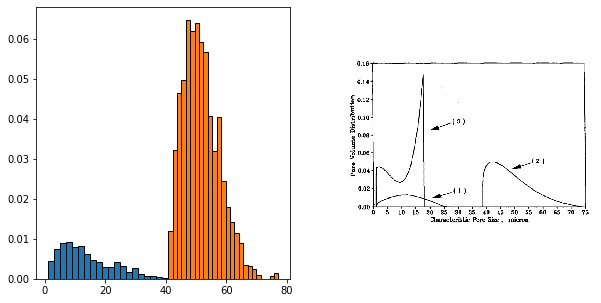

In [45]:
fig, ax = plt.subplots(1, 2, figsize=[10, 5])
f = ax[0].hist(x=geo['throat.size']*1e6, bins=25,
               weights=geo['throat.volume']*(1e3)**3, edgecolor='k')
f = ax[0].hist(x=geo['pore.size_z']*1e6, bins=25,
               weights=geo['pore.volume']*(1e3)**3, edgecolor='k')

from skimage import io
file = r"C:\Users\Jeff\Dropbox\Flash Sync\Code\Git\OpenPNM\examples\fixtures\Figure 16.png"
im = io.imread(file, as_gray=True)
ax[1].imshow(im, cmap=plt.cm.gray)
ax[1].axis('off')

Next we'll run some simulations to validate the geometry against results in the source paper.  To do this we start by adding phase object that contain the physical properties of the fluids, and physics objects which will be *generic* classes to start and we'll add the appropriate models later:

In [46]:
hg = op.phases.Mercury(network=net)
air = op.phases.Air(network=net)
water = op.phases.Water(network=net)
hg['throat.contact_angle'] = 140
hg['throat.surface_tension'] = 0.48
water['throat.viscosity'] = 0.0001

phys_air = op.physics.GenericPhysics(network=net, phase=air, geometry=geo)
phys_hg = op.physics.GenericPhysics(network=net, phase=hg, geometry=geo)
phys_water = op.physics.GenericPhysics(network=net, phase=water, geometry=geo)


First, let's compare mercury intrusion capillary pressure curves.  One key feature of the original paper is that pore and throats are cuboids with a specified aspect ratio (i.e. flattened).  This shape affects both transport and capillary properties.  In terms of capillary pressure, the normally used Washburn eqauation ($Pc=-2\sigma cos(\theta) / R $) must be modified since the throat opening has two principle radii of curvature.  Thus, the capillary entry pressure is:

$$ Pc = -\sigma cos(\theta) \bigg(\frac{1}{R_1} + \frac{1}{R_2}\bigg) $$

This equation is implemented in ``openpnm.models.physics.capillary_pressure.washburn_slit``.  It is applied as follows:

SOURCE     : openpnm.algorithms.OrdinaryPercolation.get_intrusion_data 
TIME STAMP : 2020-02-09 23:39:28,037


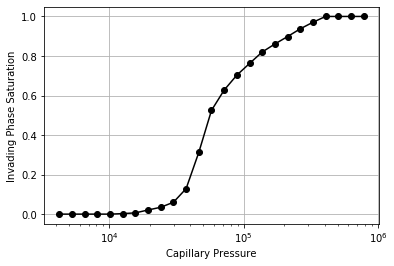

In [47]:
mod = op.models.physics.capillary_pressure.washburn_slit
phys_hg.add_model(propname='throat.entry_pressure', model=mod)

mip = op.algorithms.Porosimetry(network=net)
mip.setup(phase=hg)
mip.set_inlets(net.pores(['top', 'bottom']))
mip.run(points=25)
fig = mip.plot_intrusion_curve()

Now we can calculate directional permeability of the network using a modified version of the Hagen-Poiseulle equation to calculate throat and pore hydraulic conductances to account for the unequal aspect ratio of the throat. The equations are implemented in `openpnm.models.physics.hydraulic_conductance.hagen_poiseuille_slit` and are applied as follows:

In [49]:
mod = op.models.physics.hydraulic_conductance.hagen_poiseuille_slit
phys_water.add_model(propname='throat.hydraulic_conductance', model=mod)

In [51]:
Nx, Ny, Nz = net.shape
Lx, Ly, Lz = net.spacing

In [52]:
alg = op.algorithms.StokesFlow(network=net, phase=water)
BC1_pores = net.pores('pore.front')
alg.set_value_BC(values=202650, pores=BC1_pores)
BC2_pores = net.pores('pore.back')
alg.set_value_BC(values=101325, pores=BC2_pores)
alg.run()
Q = alg.rate(pores=net.pores('front'))

A = (Ly*Lz)*(Ny*Nz)
L = Lx*Nx
mu = sp.mean(water['throat.viscosity'])
Kxx = Q*mu*L/(A*101325)
print("The permeability coefficient is:", Kxx/1e-15, 'mD')

The permeability coefficient is: [247.53977533] mD


The reported value is 344 mD

Calculating porosity - Network porosity is the ratio of void volume (sum of throat and pore volumes) to the bulk volume and is implemented as follows: 

In [53]:
Vp = geo['pore.volume'][net.Ps]
Vt = geo['throat.volume'][net.Ts]
Vps = sp.sum(Vp)
Vts = sp.sum(Vt)
Vt = Vps + Vts
Vb = Nx*Ny*Nz*Lx*Ly*Lz
e = Vt/Vb
print("The porosity is:", e)

The porosity is: 0.17410493257743498


Calculating Formation Factor - To calculate the Formation Factor we have made electrcal conductance model using a rectangular geometry for throats and square flattened geometry for the pores. For the pores we are using a truncated pyramid shape and average out the areas at the inlet and outlet. The equations are implemented in `openpnm.models.physics.electrical_conductance.slit` and are implemented as follows:

In [54]:
mod = op.models.physics.electrical_conductance.slit
phys_water.add_model(propname='throat.electrical_conductance', model=mod)

Om = op.algorithms.OhmicConduction(network=net, phase=water)
BC1_pores = net.pores('pore.front')
Om.set_value_BC(values=20, pores=BC1_pores)
BC2_pores = net.pores('pore.back')
Om.set_value_BC(values=0, pores=BC2_pores)
Om.run()
I = Om.rate(pores=net.pores('front'))

A = (Ly*Lz)*Ny*Nz
L = Lx*Nx
delta_V = 20
Rnet = delta_V*A/(I*L)
F = Rnet
print("The formation factor is:", F)

The formation factor is: [33.36962538]


The reported value is 24.7.